In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [28]:
# Load the MNIST dataset of handwritten digits
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [29]:
# Function to one-hot encode the labels
def oneHotEncode(x, n_col=None):
    # If the number of columns isn't specified, set it to the max value in x plus one
    if not n_col:
        n_col = np.amax(x) + 1
    # Create a zero matrix of shape (number of samples, number of columns)
    one_hot = np.zeros((x.shape[0], n_col))
    # Set the appropriate elements to 1
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

In [30]:
# One-hot encode the training and test labels
y_train, y_test = oneHotEncode(y_train.astype("int")), oneHotEncode(y_test.astype("int"))
# Normalize the image data to the range [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

In [31]:
# Flatten the 28x28 images into 784-dimensional vectors
X_train, X_test = X_train.reshape(-1, 28*28), X_test.reshape(-1, 28*28)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [32]:
# Define input dimension (784) and output dimension (10 for 10 digits)
n_input_dim = 28*28
n_out = 10

In [33]:
# Define an Activation class to handle different activation functions
class Activation:
    def __init__(self, activation, name="activation"):
        self.activation = activation
        self.gradient = activation.gradient
        self.input = None
        self.output = None
        self.name = name

    def forward(self, x):
        # Store input and calculate output using the activation function
        self.input = x
        self.output = self.activation(x)
        return self.output

    def backward(self, output_error, lr=0.01):
        # Calculate the gradient of the loss with respect to the input
        return self.gradient(self.input) * output_error

    def __call__(self, x):
        # Make the object callable and perform the forward pass
        return self.forward(x)

In [34]:
# Define a Linear (fully connected) layer
class Linear:
    def __init__(self, n_in, n_out, name="linear"):
        # Initialize weights and biases with small random values
        limit = 1 / np.sqrt(n_in)
        self.W = np.random.uniform(-limit, limit, (n_in, n_out))
        self.b = np.zeros((1, n_out))
        self.input = None
        self.output = None
        self.name = name

    def forward(self, x):
        # Perform the linear transformation
        self.input = x
        self.output = np.dot(self.input, self.W) + self.b
        return self.output

    def backward(self, output_error, lr=0.01):
        # Compute the gradient with respect to the input, weights, and biases
        input_error = np.dot(output_error, self.W.T)
        delta = np.dot(self.input.T, output_error)

        # Update weights and biases using gradient descent
        self.W -= lr * delta
        self.b -= lr * np.mean(output_error, axis=0, keepdims=True)
        return input_error

    def __call__(self, x):
        # Make the object callable and perform the forward pass
        return self.forward(x)

In [35]:
# Define the ReLU activation function
class ReLU:
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, x):
        return self.activation(x)

    def activation(self, x):
        # ReLU activation: max(0, x) with leaky part
        return np.where(x >= 0, x, self.alpha * x)

    def gradient(self, x):
        # Gradient of ReLU: 1 for x >= 0, alpha otherwise
        return np.where(x >= 0, 1, self.alpha)

In [36]:
# Define the Softmax activation function
class Softmax:
    def __call__(self, x):
        return self.activation(x)

    def activation(self, x):
        # Softmax activation: e^x / sum(e^x)
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

    def gradient(self, x):
        # Gradient of Softmax: p * (1 - p)
        p = self.activation(x)
        return p * (1 - p)

In [37]:
# Define the neural network architecture
class Network:
    def __init__(self, input_dim, output_dim, lr=0.01):
        # Create the network layers
        self.layers = [
            Linear(input_dim, 256, name="input"),
            Activation(ReLU(), name="relu1"),
            Linear(256, 128, name="hidden1"),
            Activation(ReLU(), name="relu2"),
            Linear(128, output_dim, name="output"),
            Activation(Softmax(), name="softmax")
        ]
        self.lr = lr

    def forward(self, x):
        # Perform forward pass through all layers
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, loss_grad):
        # Perform backward pass through all layers
        for layer in reversed(self.layers):
            loss_grad = layer.backward(loss_grad, self.lr)

    def __call__(self, x):
        # Make the object callable and perform the forward pass
        return self.forward(x)

In [38]:
# Define the Cross-Entropy loss function
class CrossEntropy:
    def __init__(self):
        pass

    def loss(self, y, p):
        # Calculate the cross-entropy loss
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return -np.sum(y * np.log(p), axis=1)

    def gradient(self, y, p):
        # Calculate the gradient of the cross-entropy loss
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return -(y / p) + (1 - y) / (1 - p)

In [39]:
# Initialize the loss function and the model
criterion = CrossEntropy()
model = Network(n_input_dim, n_out, lr=1e-3)

In [40]:
# Training parameters
EPOCHS = 10
BATCH_SIZE = 64

In [41]:
# Generator function to load data in batches
def batchLoader(X, y=None, batch_size=BATCH_SIZE):
    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i + batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]

In [42]:
# Function to calculate accuracy
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [43]:
# Initialize lists to store training loss and accuracy history
train_loss_history = []
train_acc_history = []

In [44]:
# Training loop
for epoch in range(EPOCHS):
    loss = []
    acc = []
    for x_batch, y_batch in batchLoader(X_train, y_train):
        # Forward pass
        out = model(x_batch)
        # Compute loss and accuracy
        loss.append(np.mean(criterion.loss(y_batch, out)))
        acc.append(accuracy(np.argmax(y_batch, axis=1), np.argmax(out, axis=1)))
        # Backward pass
        error = criterion.gradient(y_batch, out)
        model.backward(error)

    # Compute mean loss and accuracy for the epoch
    mean_loss = np.mean(loss)
    mean_acc = np.mean(acc)
    train_loss_history.append(mean_loss)
    train_acc_history.append(mean_acc)
    print(f"Epoch {epoch + 1}, Loss: {mean_loss}, Acc: {mean_acc}")

Epoch 1, Loss: 0.5752995890419116, Acc: 0.8523121002132196
Epoch 2, Loss: 0.2550150071933093, Acc: 0.9262393390191898
Epoch 3, Loss: 0.18894560860660764, Acc: 0.9452292110874201
Epoch 4, Loss: 0.14916269112377065, Acc: 0.9563399520255863
Epoch 5, Loss: 0.12287298014567197, Acc: 0.9641191364605544
Epoch 6, Loss: 0.10391104539467873, Acc: 0.9704824093816631
Epoch 7, Loss: 0.0893025283526879, Acc: 0.974646855010661
Epoch 8, Loss: 0.07766575487216205, Acc: 0.9776619136460555
Epoch 9, Loss: 0.0680715630681454, Acc: 0.9807935767590619
Epoch 10, Loss: 0.060047785091066265, Acc: 0.9836420575692963


In [45]:
# Evaluate the model on the test set
out = model(X_test)
test_accuracy = accuracy(np.argmax(y_test, axis=1), np.argmax(out, axis=1))
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9736


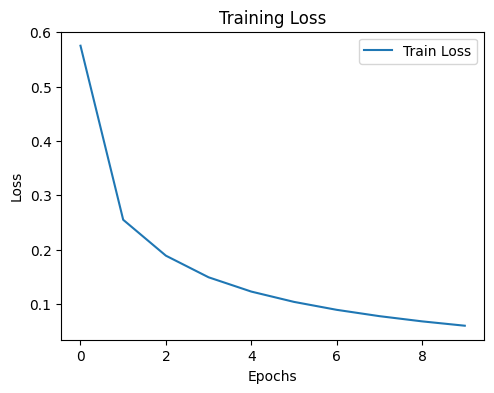

In [46]:
# Plot training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

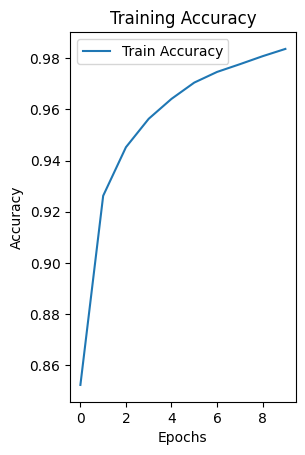

In [47]:
# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

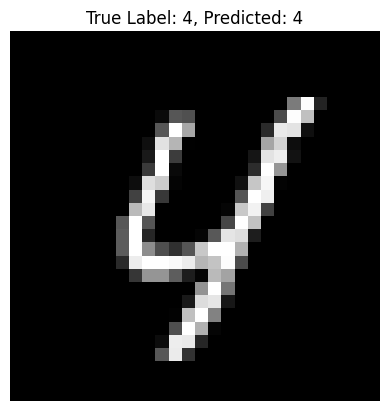

In [48]:
# Function to plot an image with its predicted and true labels
def plot_image_with_prediction(model, X_test, y_test, index):
    image = X_test[index].reshape(28, 28)

    # Get the model's prediction for the given image
    prediction = model(X_test[index].reshape(1, -1))
    predicted_label = np.argmax(prediction)
    true_label = np.argmax(y_test[index])

    # Plot the image with the true and predicted labels
    plt.imshow(image, cmap='gray')
    plt.title(f"True Label: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Plot a specific image with its prediction
plot_image_with_prediction(model, X_test, y_test, index=555)